# Project: 01-2024 LaborDE Analysis
## Author: Nadia Ordonez
## Step 6 LD Unsupervised machine learning Clustering

* [1. Introduction](#1.-Introduction)
* [2. Importing data](#2.-Importing-data)  
    * [2.1 Importing libraries](#2.1-Importing-libraries) 
    * [2.2 Importing dataframe](#2.2-Importing-dataframe)
* [3. Data wrangling before clustering](#3.-Data-wrangling-before-clustering)
* [4. Clustering analysis](#4.-Clustering-analysis)
    * [4.1 The elbow technique](#4.1-The-elbow-technique) 
    * [4.2 k means](#4.2-k-means)
    * [4.3 Plotting clusters](#4.3-Plotting-clusters)
    * [4.4 Cluster basis stats](#4.4-Cluster-basic-stats)
* [5. Data driven insights](#5.-Data-driven-insights)

# 1. Introduction

In Step 3 Exploring relationships, Bundesländer were manually categorized into three groups based solely on the number of potential laboratory customers for our client, LaborDE. Now, I aim to leverage unsupervised machine learning techniques, specifically the k-means clustering algorithm. This algorithm, a widely used clustering method, iteratively partitions data points into k clusters based on their similarity.

The k-means algorithm minimizes the within-cluster variance, assigning data points to clusters in a way that maximizes their similarity within the cluster and minimizes the dissimilarity between clusters. In this case, I will apply the algorithm to all numerical variables available in my dataframe at the Bundesland level.

The selected algorithm will analyze patterns in the dataframe, suggesting the optimal number of groups for data point grouping. In this business project, my objective is to investigate how Bundesländer can be clustered based on their unique features. The aim is to identify Bundesländer with the highest business potential for our client.

# 2. Importing data

## 2.1 Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans # Here is where you import the k-means algorithm from scikit-learn.
from sklearn.preprocessing import StandardScaler # to standardize data
import pylab as pl # PyLab is a convenience module that bulk imports matplotlib.

import warnings # This is a library that handles warnings.
warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

In [2]:
# This option ensures that the graphs you create are displayed within the notebook without the need to "call" them specifically.

%matplotlib inline

## 2.2 Importing dataframe

In [3]:
# Define path
path = r'C:\Users\Ich\Documents\01_2024_LaborDE_analysis'

In [4]:
# Import df
df = pd.read_csv(os.path.join(path,'02_Data', 'Prepared_data', 'company_bundesland_step2.csv'), encoding='utf-8')

In [5]:
df.columns

Index(['bundesland_en', 'company_total', 'labor_total', 'cancer_total',
       'plz_total', 'administration_unit_id', 'bundesland_de', 'area_sqkm',
       'population', 'male', 'female', 'population_per_sqkm', 'gdp_mill_euro'],
      dtype='object')

In [6]:
df.head()

,bundesland_en,company_total,labor_total,cancer_total,plz_total,administration_unit_id,bundesland_de,area_sqkm,population,male,female,population_per_sqkm,gdp_mill_euro
0,Baden-Württemberg,299894,1381,133,2073,8,Baden-Württemberg,35748.20,11069533.0,5501693.0,5567840.0,310.0,572837
1,Bavaria,412937,1604,158,3160,9,Bayern,70541.61,13076721.0,6483793.0,6592928.0,185.0,716784
2,Berlin,142570,668,75,1318,11,Berlin,891.12,3644826.0,1792801.0,1852025.0,4090.0,179379
3,Brandenburg,57793,247,31,570,12,Brandenburg,29654.48,2511917.0,1239460.0,1272457.0,85.0,88800
4,Bremen,21891,115,9,157,4,Bremen,419.36,682986.0,338035.0,344951.0,1629.0,38698


In [7]:
df.shape

(16, 13)

# 3. Data wrangling before clustering

## Selecting numerical variables

In [8]:
# Subsetting dataframe
selected_variables = ['company_total', 'labor_total', 'cancer_total', 'plz_total', 'area_sqkm', 'population', 'male', 'female', 'population_per_sqkm', 'gdp_mill_euro']
sub_df = df[selected_variables]

In [9]:
# See results
sub_df.head()

,company_total,labor_total,cancer_total,plz_total,area_sqkm,population,male,female,population_per_sqkm,gdp_mill_euro
0,299894,1381,133,2073,35748.20,11069533.0,5501693.0,5567840.0,310.0,572837
1,412937,1604,158,3160,70541.61,13076721.0,6483793.0,6592928.0,185.0,716784
2,142570,668,75,1318,891.12,3644826.0,1792801.0,1852025.0,4090.0,179379
3,57793,247,31,570,29654.48,2511917.0,1239460.0,1272457.0,85.0,88800
4,21891,115,9,157,419.36,682986.0,338035.0,344951.0,1629.0,38698


In [10]:
# Basic descriptive analysis
sub_df.describe()
# Values within variables are quite different among variables therefore data needs to be standarized prior to analysis

,company_total,labor_total,cancer_total,plz_total,area_sqkm,population,male,female,population_per_sqkm,gdp_mill_euro
count,16.000000,16.000000,16.000000,16.000000,16.000000,1.600000e+01,1.600000e+01,1.600000e+01,16.000000,16.000000
mean,149594.687500,625.937500,75.750000,1124.062500,22348.427500,5.188701e+06,2.560418e+06,2.628283e+06,689.437500,241690.625000
std,143929.614759,591.354769,70.338704,843.152218,18697.298273,4.936479e+06,2.434791e+06,2.501830e+06,1112.281857,244717.928213
min,21891.000000,115.000000,9.000000,157.000000,419.360000,6.829860e+05,3.380350e+05,3.449510e+05,69.000000,38505.000000
25%,48823.750000,211.750000,24.000000,499.750000,12496.002500,2.067654e+06,1.021122e+06,1.046531e+06,158.250000,74434.500000
50%,91395.500000,388.000000,48.500000,906.000000,20153.065000,3.270769e+06,1.606129e+06,1.664640e+06,213.500000,145365.500000
75%,201430.500000,807.500000,124.000000,1518.000000,30768.937500,6.694969e+06,3.305594e+06,3.389375e+06,420.250000,327367.500000
max,505294.000000,2112.000000,267.000000,3160.000000,70541.610000,1.793265e+07,8.798631e+06,9.134020e+06,4090.000000,793790.000000


## Standarize data

In [11]:
# Using Standard Scaler to standardize our data
scaler = StandardScaler()
sub_df_std = scaler.fit_transform(sub_df) 

# 4. Clustering analysis

## 4.1 The elbow technique

The optimal number of clusters shouldn’t be too many (otherwise, there won’t be much difference between them), while also not being too few (otherwise, you won’t get enough granularity). What the elbow technique does, then, is showing the breaking point, or “elbow,” at which adding more clusters won’t help better explain the variances in the data.

In [12]:
num_cl = range(1, 8) # Defines the range of potential clusters in the data
# since there are 16 Bundesländer in Germany, then I set a maximum of 8 cluster among them
kmeans = [KMeans(n_clusters=i) for i in num_cl] # Defines k-means clusters in the range assigned above

In [13]:
score = [kmeans[i].fit(sub_df_std).score(sub_df_std) for i in range(len(kmeans))] 
# Creates a score that represents a rate of variation for the given cluster option.
score

[-160.0,
 -55.133443006088825,
 -35.76730481375208,
 -20.668425369925068,
 -14.556562326062107,
 -10.281462516587382,
 -7.043015094030226]

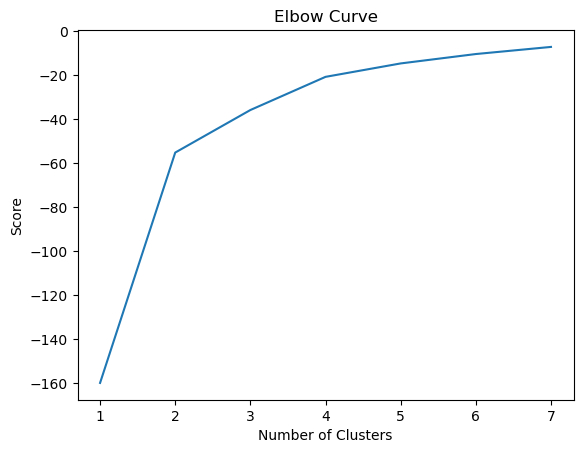

In [14]:
# Plot the elbow curve using PyLab.
pl.plot(num_cl,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In this example, there's a particularly large jump from one to two on the x-axis, but after two the curve straightens out. This means that the optimal count for my cluster is two.

## 4.2 k means

In [15]:
# Create the k-means objecs
kmeans = KMeans(n_clusters = 2)

In [16]:
# Fit the k-means object to the data.
kmeans.fit(sub_df)

KMeans(n_clusters=2)

In [17]:
df['clusters'] = kmeans.fit_predict(sub_df)

In [18]:
df

,bundesland_en,company_total,labor_total,cancer_total,plz_total,administration_unit_id,bundesland_de,area_sqkm,population,male,female,population_per_sqkm,gdp_mill_euro,clusters
0,Baden-Württemberg,299894,1381,133,2073,8,Baden-Württemberg,35748.20,11069533.0,5501693.0,5567840.0,310.0,572837,0
1,Bavaria,412937,1604,158,3160,9,Bayern,70541.61,13076721.0,6483793.0,6592928.0,185.0,716784,0
2,Berlin,142570,668,75,1318,11,Berlin,891.12,3644826.0,1792801.0,1852025.0,4090.0,179379,1
3,Brandenburg,57793,247,31,570,12,Brandenburg,29654.48,2511917.0,1239460.0,1272457.0,85.0,88800,1
4,Bremen,21891,115,9,157,4,Bremen,419.36,682986.0,338035.0,344951.0,1629.0,38698,1
5,Hamburg,90427,340,33,962,2,Hamburg,755.09,1841179.0,902048.0,939131.0,2438.0,144220,1
6,Hesse,195520,812,139,1746,6,Hessen,21115.67,6265809.0,3093044.0,3172765.0,297.0,323352,1
7,Lower Saxony,219162,806,121,1442,3,Niedersachsen,47709.51,7982448.0,3943243.0,4039205.0,167.0,339414,1
8,Mecklenburg-Western Pomerania,37426,183,24,462,13,Mecklenburg-Vorpommern,23293.61,1609675.0,793639.0,816036.0,69.0,53440,1
9,North Rhine-Westphalia,505294,2112,267,2310,5,Nordrhein-Westfalen,34112.31,17932651.0,8798631.0,9134020.0,526.0,793790,0


In [19]:
df['clusters'].value_counts()

clusters
1    13
0     3
Name: count, dtype: int64

As a resul of our clustering modeling, two clusters were created with Bundesländer NRW, Bayer and Baden-Württenberg being cluster within 0 and the rest of them Bundesländer within 1. 

## 4.3 Plotting clusters

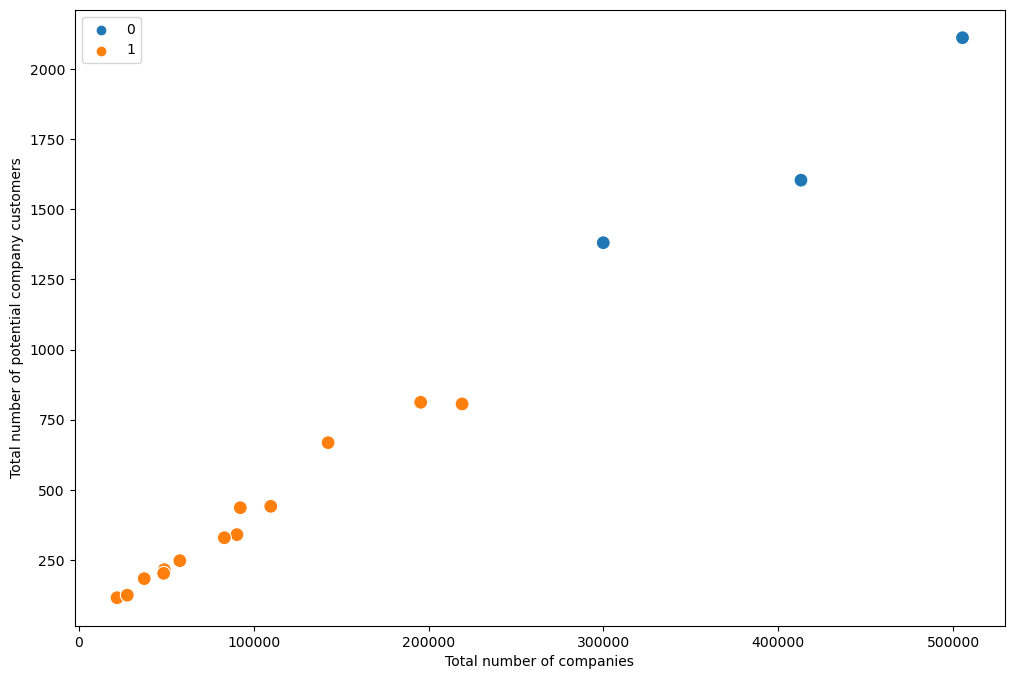

In [20]:
# Plot the clusters for the "company_total" and "labor_total" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df['company_total'], y=df['labor_total'], hue=kmeans.labels_, s=100) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('Total number of companies') # Label x-axis.
plt.ylabel('Total number of potential company customers') # Label y-axis.
plt.show()

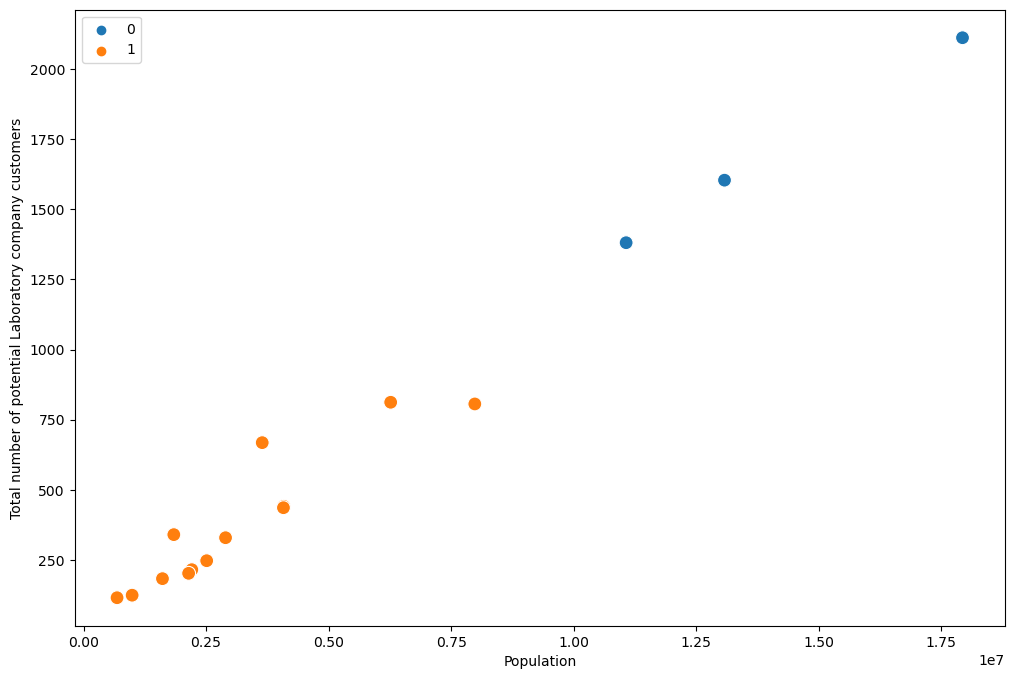

In [21]:
# Plot the clusters for the "labor_total" and "population" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df['population'], y=df['labor_total'], hue=kmeans.labels_, s=100)

ax.grid(False) 
plt.xlabel('Population') 
plt.ylabel('Total number of potential Laboratory company customers') 

# Save the cluster plot
plt.savefig(os.path.join(path, '04_Analysis', 'Visuals', 'cluster_labor_vs_population_bundesland.png'))

# Display the plot
plt.show()

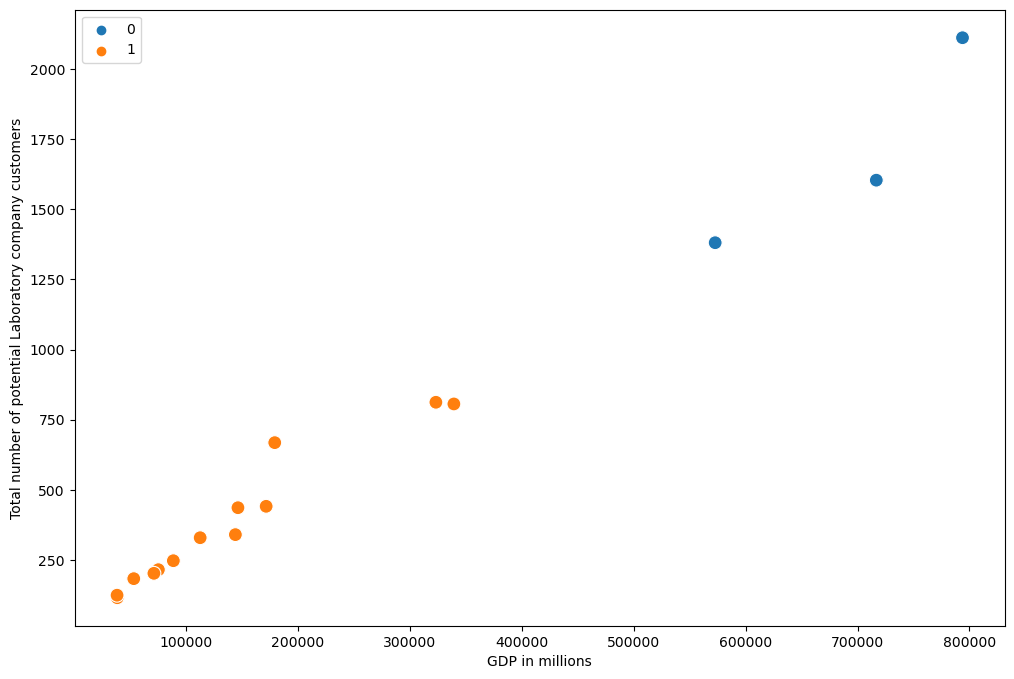

In [22]:
# Plot the clusters for the "labor_total" and "gdp" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df['gdp_mill_euro'], y=df['labor_total'], hue=kmeans.labels_, s=100)

ax.grid(False) 
plt.xlabel('GDP in millions') 
plt.ylabel('Total number of potential Laboratory company customers') 
# Save the cluster plot
plt.savefig(os.path.join(path, '04_Analysis', 'Visuals', 'cluster_labor_vs_gdp_bundesland.png'))

# Display the plot
plt.show()

The visual analysis of the plots indicates that Bundesländer falling into Cluster 1 exhibit distinctive characteristics, including a sizable population, high GDP, significant industrial activity, and notably, a substantial number of potential company customers—considered crucial from the business perspective of our client. Consequently, this cluster will be appropriately labeled as "high business potential." In contrast, the remaining cluster, lacking these prominent attributes, will be designated as "low business potential." 

## 4.4 Cluster basic stats

In [23]:
# Labeling cluster 
df.loc[df['clusters'] == 1, 'cluster'] = 'high business potential'
df.loc[df['clusters'] == 0, 'cluster'] = 'low business potential'

In [24]:
df.groupby('cluster').agg({'company_total':['mean', 'median'], 
                         'labor_total':['mean', 'median'], 
                         'cancer_total':['mean', 'median'],
                           'area_sqkm':['mean', 'median'],
                          'population':['mean', 'median']})

company_total            labor_total          \
                                  mean    median         mean  median   
cluster                                                                 
high business potential   90414.615385   83243.0   378.307692   329.0   
low business potential   406041.666667  412937.0  1699.000000  1604.0   

                        cancer_total            area_sqkm            \
                                mean median          mean    median   
cluster                                                               
high business potential    50.307692   33.0  16705.593846  18449.95   
low business potential    186.000000  158.0  46800.706667  35748.20   

                           population              
                                 mean      median  
cluster                                            
high business potential  3.149254e+06   2511917.0  
low business potential   1.402630e+07  13076721.0

In our cluster analysis, the "high business potential" cluster stands out with significantly higher mean and median values for key parameters, including company total, labor total, and cancer total. This suggests that the "blue" cluster comprises regions with heightened economic activity, specifically in the industrial sector, including potential laboratory and cancer-related enterprises—entities aligning with the target customer profile of our client, LaborDE.

Additionally, the "high business potential" cluster demonstrates superior mean and median values for area_sqkm and population. This indicates that it likely represents Bundesländer with larger areas and populations on average, highlighting both economic vibrancy and providing valuable context for demographic and spatial characteristics.

### Exporting data

In [25]:
# Exporting to prepared data folder
#"index = False" avoids the automatic creation of an unnamed column in the exported csv file
df.to_csv(os.path.join(path, '02_Data','Prepared_data', 'company_bundesland_step6.csv'), index = False)

# 5. Data driven insights

The k-means clustering algorithm has recommended dividing our datapoints into two distinct clusters. This analysis encompassed all numerical variables in my dataframe, including industrial activity, demographic factors, and financial indicators at the Bundesland level. In contrast to the previous manual grouping of Bundesländer into three categories in Step 3, where a single variable was considered, the applied algorithm suggests that clustering based on all variables provides a more comprehensive perspective.

For our client, LaborDE, this analysis highlights Bayern and Baden-Württemberg as optimal Bundesländer for conducting business operations. Interestingly, NRW, where our client is currently located, also falls within the cluster characterized by "high business potential".

Next Steps: To validate these findings, statistical tests to assess the statistical significance of the differences between the identified clusters is advised. This will provide a more robust foundation for strategic decision-making based on the clustering results.